In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

2023-04-03 21:50:17.806024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data

train = pd.read_csv('MNIST/train.csv')
test = pd.read_csv('MNIST/test.csv')

y = train['label']
X = train.drop('label', axis=1)

X = X/255.0
test = test/255.0

In [3]:
# Reshape and Split

X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
y = to_categorical(y, num_classes = 10)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

In [4]:
print("Training Set Shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("Testing Set Shape: ", X_val.shape)
print("Y testing shape: ", y_val.shape)

Training Set Shape:  (33600, 28, 28, 1)
Y train shape:  (33600, 10)
Testing Set Shape:  (8400, 28, 28, 1)
Y testing shape:  (8400, 10)


In [29]:
# CNN Model

model = keras.Sequential([
    layers.InputLayer(input_shape = [28,28,1]),
    
    # Preprocessing
    preprocessing.RandomTranslation(height_factor=0.05, width_factor=0.05),
    preprocessing.RandomRotation(factor=0.05),
    layers.RandomZoom(.1, .1),

    # Conv2D 1
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters = 64, kernel_size = [5,5], padding = 'same', activation ='relu'),
    layers.MaxPool2D(pool_size=2),
    
    # Conv2D 2
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters = 64, kernel_size = [3,3], padding = 'same', activation ='relu'),
    layers.MaxPool2D(pool_size=2),
    
    # Conv2D 3
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters = 32, kernel_size = [3,3], padding = 'same', activation ='relu'),
    layers.MaxPool2D(pool_size=2),
    
    # Dense 1
    layers.Flatten(),
    layers.BatchNormalization(renorm=True),
    layers.Dense(256, activation = "relu"),
    layers.Dropout(0.3),

    # Dense 2 (Output)
    layers.Dense(10, activation = "softmax", name = 'output'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.0005,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=80,
    callbacks=[early_stopping],
)

Epoch 1/50


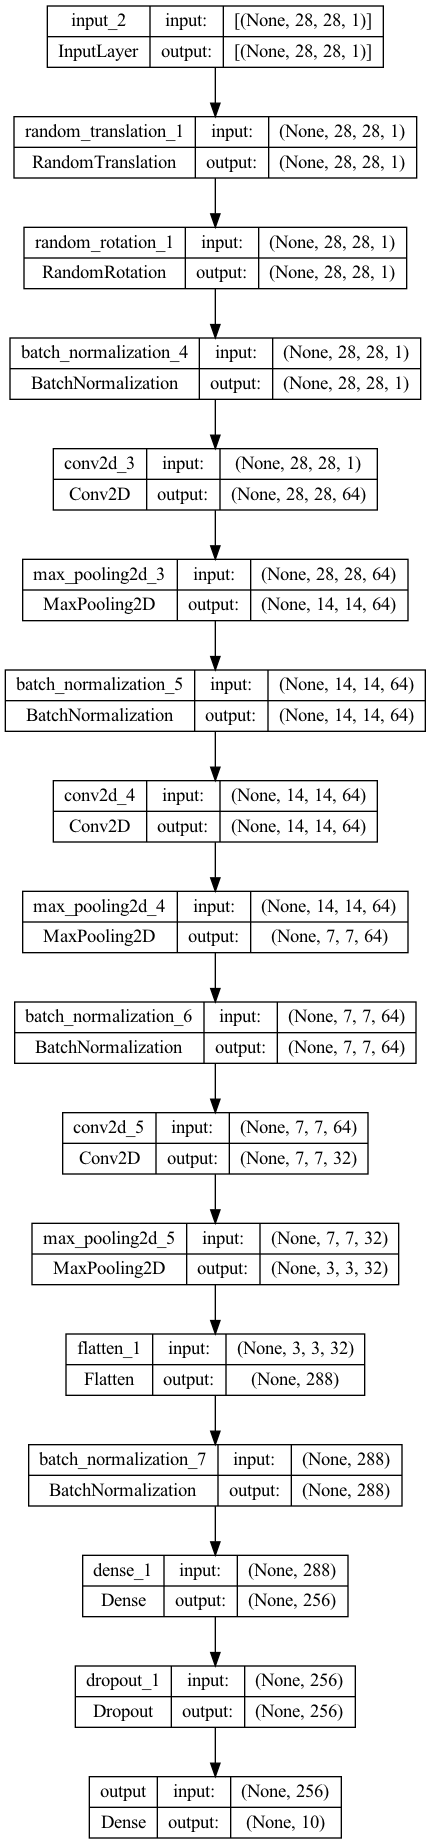

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file='my_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

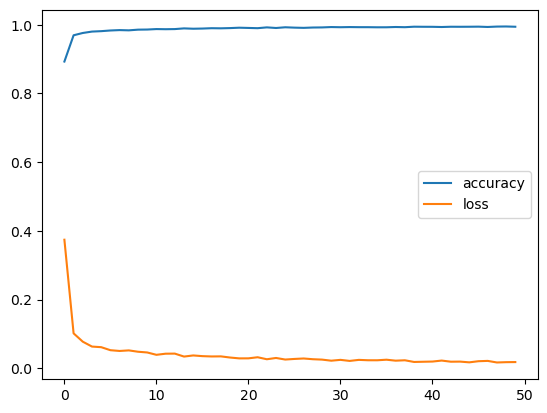

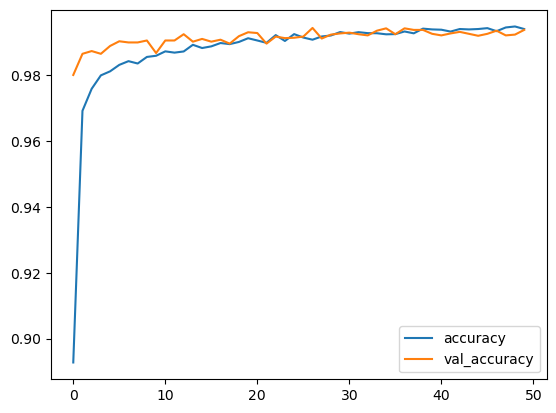

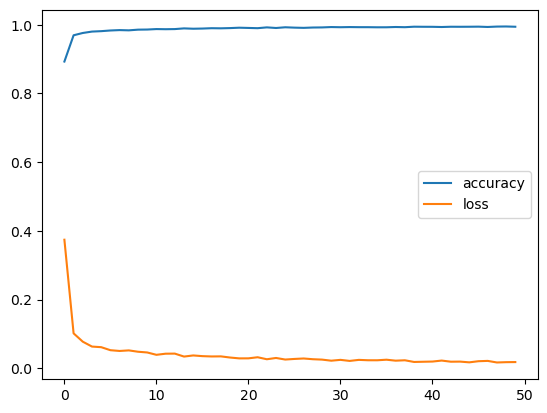

In [21]:
history_df = pd.DataFrame(history.history)

plot1 = history_df.loc[:, ['accuracy', 'val_accuracy']].plot().get_figure()
plot2 = history_df.loc[:, ['accuracy', 'loss']].plot().get_figure()

plot1.savefig('accuracy_val_accuracy.png')
plot2.savefig('accuracy_loss.png')

plot1
plot2

263/263 [==============================] - 2s 7ms/step


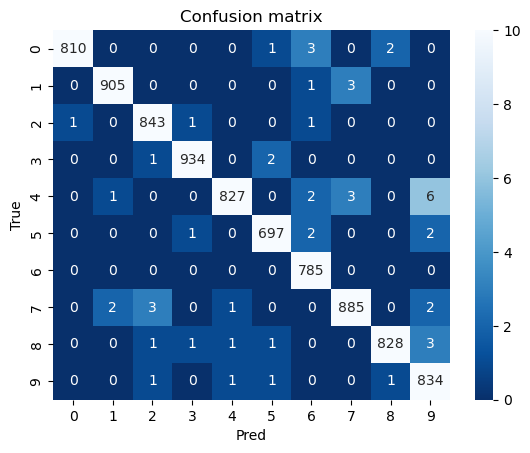

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_val), axis=1)
cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues_r', fmt='g', vmax=10)
plt.title('Confusion matrix')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation_4 (Rando  (None, 28, 28, 1)        0         
 mTranslation)                                                   
                                                                 
 random_rotation_4 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 batch_normalization_17 (Bat  (None, 28, 28, 1)        7         
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        1664      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                 

In [24]:
model.save('digit_recognizer_model')

INFO:tensorflow:Assets written to: digit_recognizer_model/assets


INFO:tensorflow:Assets written to: digit_recognizer_model/assets
